<a href="https://colab.research.google.com/github/UdaraChamidu/Eye-Disease-Classification-With-Integrated-Chatbot/blob/main/Eye_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras


In [2]:
from pathlib import Path
import PIL
import os

In [3]:
import os
from pathlib import Path  # Import Path

from google.colab import drive
drive.mount('/content/drive')


folder_path = '/content/drive/MyDrive/dataset/Dataset'

glaucoma = Path(folder_path + '/Glaucoma')
cataract = Path(folder_path + '/cataract')
normal = Path(folder_path + '/normal')
diabetic_retinopathy = Path(folder_path + '/diabetic_retinopathy')
ACRIMA = Path(folder_path + '/ACRIMA')  # Fixed typo
ORIGA = Path(folder_path + '/ORIGA')  # Use "Path" instead of "path"
ODIR_5K = Path(folder_path + '/ODIR-5K')  # Use "Path"
retina_disease = Path(folder_path + '/retina_disease')  # Use "Path"


Mounted at /content/drive


In [4]:
pip install tqdm


In [5]:
from tqdm import tqdm

disease_type = [glaucoma, cataract,normal,diabetic_retinopathy,ACRIMA,ORIGA,ODIR_5K,retina_disease]
#                  0          1      2         3
df = pd.DataFrame()
 # build the dataframe
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/dataset/Dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1838.49it/s]
/content/drive/MyDrive/dataset/Dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 2261.64it/s]
/content/drive/MyDrive/dataset/Dataset/ODIR-5K: 100%|██████████| 8001/8001 [00:06<00:00, 1331.01it/s]
/content/drive/MyDrive/dataset/Dataset/retina_disease: 100%|██████████| 100/100 [00:00<00:00, 1868.20it/s]


In [6]:
df

,image,disease_type
0,/content/drive/MyDrive/dataset/Dataset/Glaucom...,0
1,/content/drive/MyDrive/dataset/Dataset/Glaucom...,0
2,/content/drive/MyDrive/dataset/Dataset/Glaucom...,0
3,/content/drive/MyDrive/dataset/Dataset/Glaucom...,0
4,/content/drive/MyDrive/dataset/Dataset/Glaucom...,0
...,...,...
13836,/content/drive/MyDrive/dataset/Dataset/retina_...,7
13837,/content/drive/MyDrive/dataset/Dataset/retina_...,7
13838,/content/drive/MyDrive/dataset/Dataset/retina_...,7
13839,/content/drive/MyDrive/dataset/Dataset/retina_...,7


In [7]:
df.disease_type.value_counts()

,count
disease_type,
6,8001
0,1175
3,1098
2,1074
1,1038
4,705
5,650
7,100


In [8]:
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy','ACRIMA','ORIGA','ODIR_5K','retina_disease']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

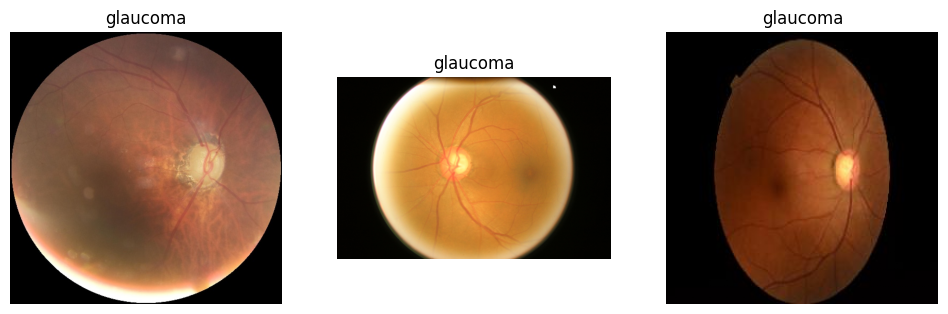

In [9]:
plot_image(0)

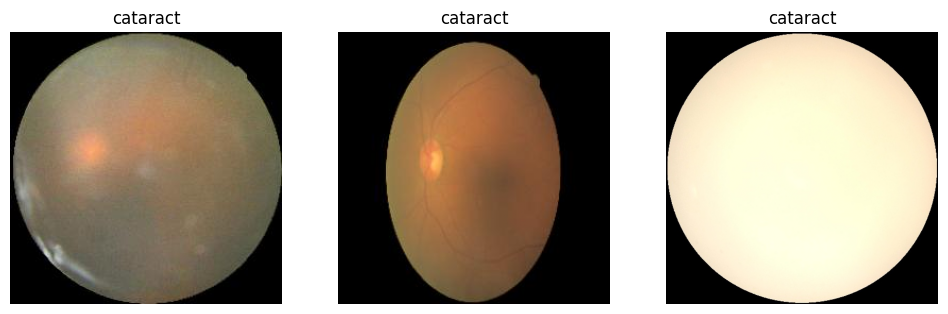

In [10]:
plot_image(1)

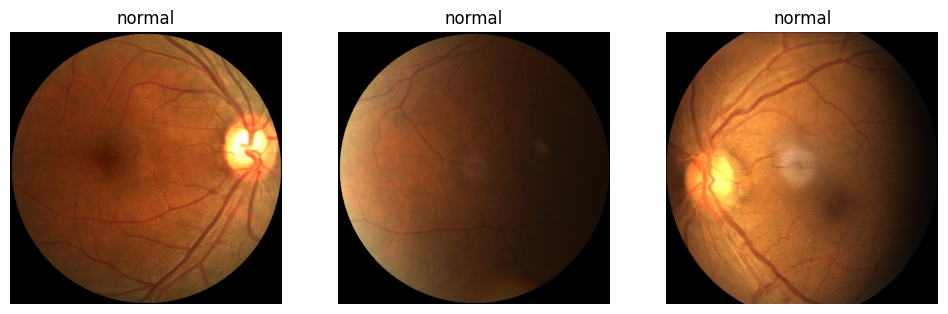

In [11]:
plot_image(2)

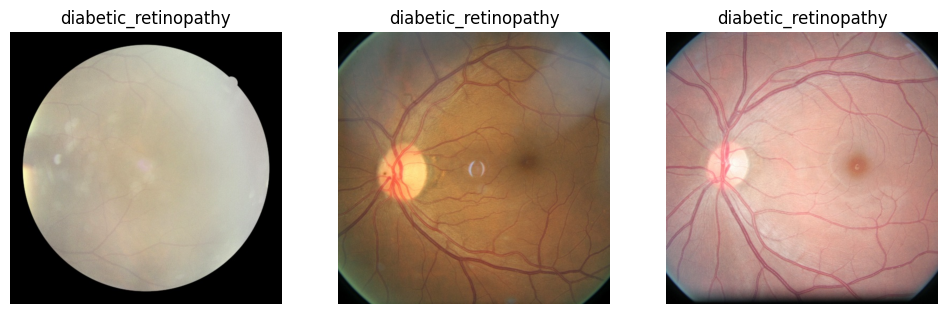

In [12]:
plot_image(3)

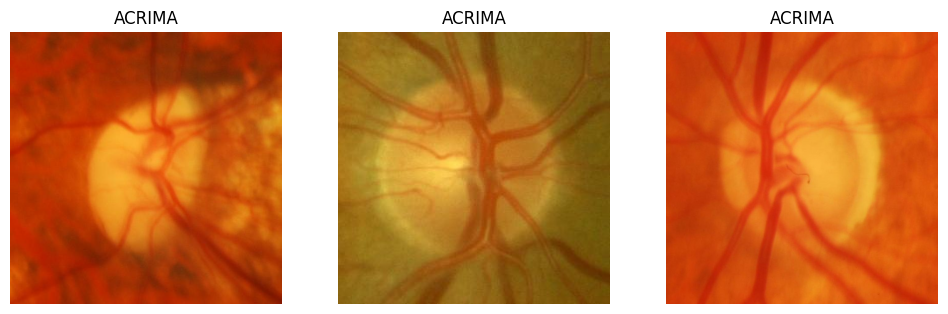

In [13]:
plot_image(4)

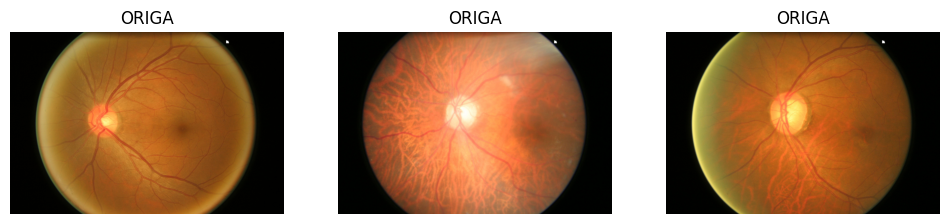

In [14]:
plot_image(5)

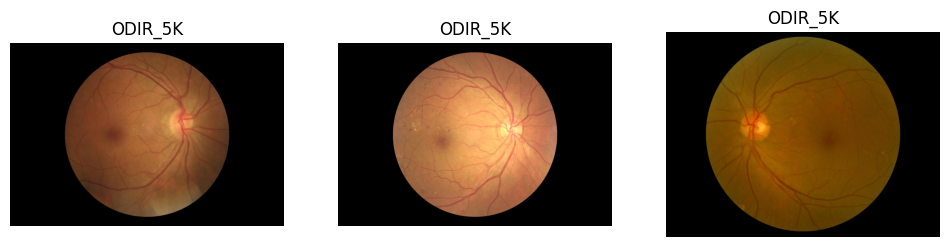

In [15]:
plot_image(6)

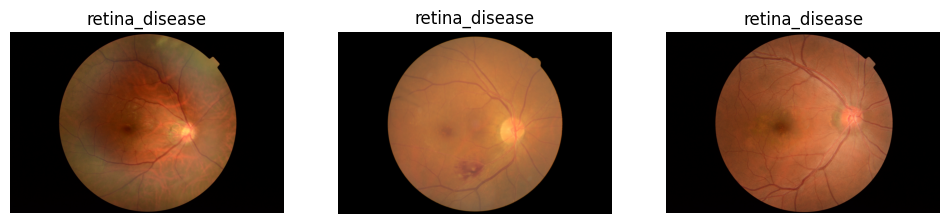

In [16]:
plot_image(7)

In [17]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy',4:'ACRIMA',5:'ORIGA',6:'ODIR_5K',7:'retina_disease'})

In [18]:
df.disease_type.value_counts()

,count
disease_type,
ODIR_5K,8001
glaucoma,1175
diabetic_retinopathy,1098
normal,1074
cataract,1038
ACRIMA,705
ORIGA,650
retina_disease,100


In [19]:
# shuffling the rows of a DataFrame df
df1=df.sample(frac=1).reset_index(drop=True)

<ipython-input-20-9a1d701cbe46>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='disease_type', data=df1, palette=custom_palette)


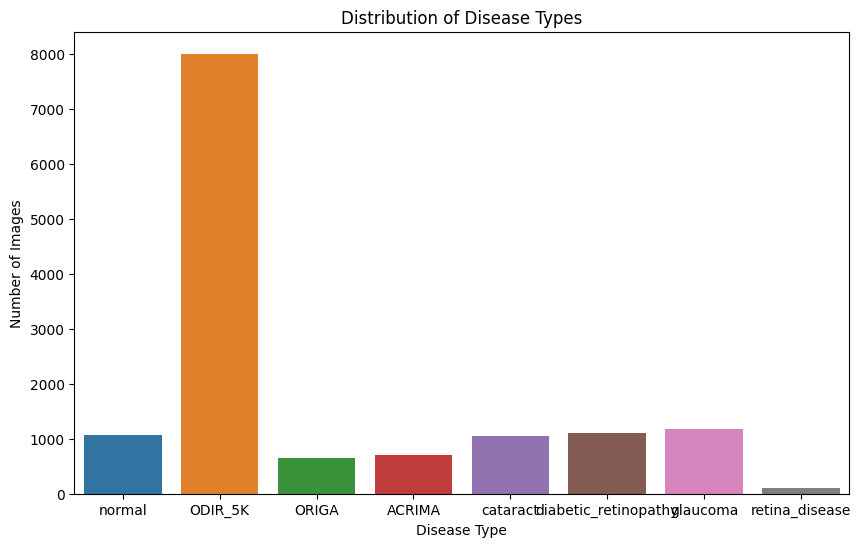

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a palette with enough colors
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

# Assuming 'df1' contains the dataset with 'disease_type' column
plt.figure(figsize=(10, 6))
sns.countplot(x='disease_type', data=df1, palette=custom_palette)

# Set labels
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Disease Types')

# Save plot
plt.savefig('countplot.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

In [22]:
from sklearn.model_selection import train_test_split

# Split your data into features (X) and labels (y)
X = df1['image']  # 'image' contains image data
y = df1['disease_type']  # 'disease_type' contains labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [24]:
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 11072 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [25]:
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 2768 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [26]:
if (train_data.class_indices == valid_data.class_indices):

    # Print that the class indices are consistent
    print("Class indices are consistent")

    # Save class indices as metadata in metadata.js
    class_indices = train_data.class_indices
    print(class_indices)
    js_code = f"const classIndices = {class_indices};\nexport default classIndices;"
    with open('metadata.js', 'w') as f:
        f.write(js_code)
else:
    print("Class indices are not consistent")

Class indices are consistent
{'ACRIMA': 0, 'ODIR_5K': 1, 'ORIGA': 2, 'cataract': 3, 'diabetic_retinopathy': 4, 'glaucoma': 5, 'normal': 6, 'retina_disease': 7}


In [27]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from keras.models import Sequential

In [28]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

In [29]:
from tensorflow.keras.applications.vgg19 import VGG19
image_size=224
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [30]:
for layer in vgg.layers:
    layer.trainable = False

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
import tensorflow as tf

# Initialize the Sequential model
model = Sequential()

# Add VGG model as the base
model.add(vgg)

# Flatten the output of the VGG model
model.add(Flatten())

# Add a fully connected dense layer with 256 units and ReLU activation
model.add(Dense(256, activation="relu"))

# Add Batch Normalization to stabilize training
model.add(tf.keras.layers.BatchNormalization())

# Add the final Dense layer with 4 units for 4 classes (change based on your output)
model.add(Dense(8, activation="softmax"))  # Change 4 to 8




In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,450,248 (100.90 MB)

 Trainable params: 6,425,352 (24.51 MB)

 Non-trainable params: 20,024,896 (76.39 MB)

In [33]:
pip install pydot

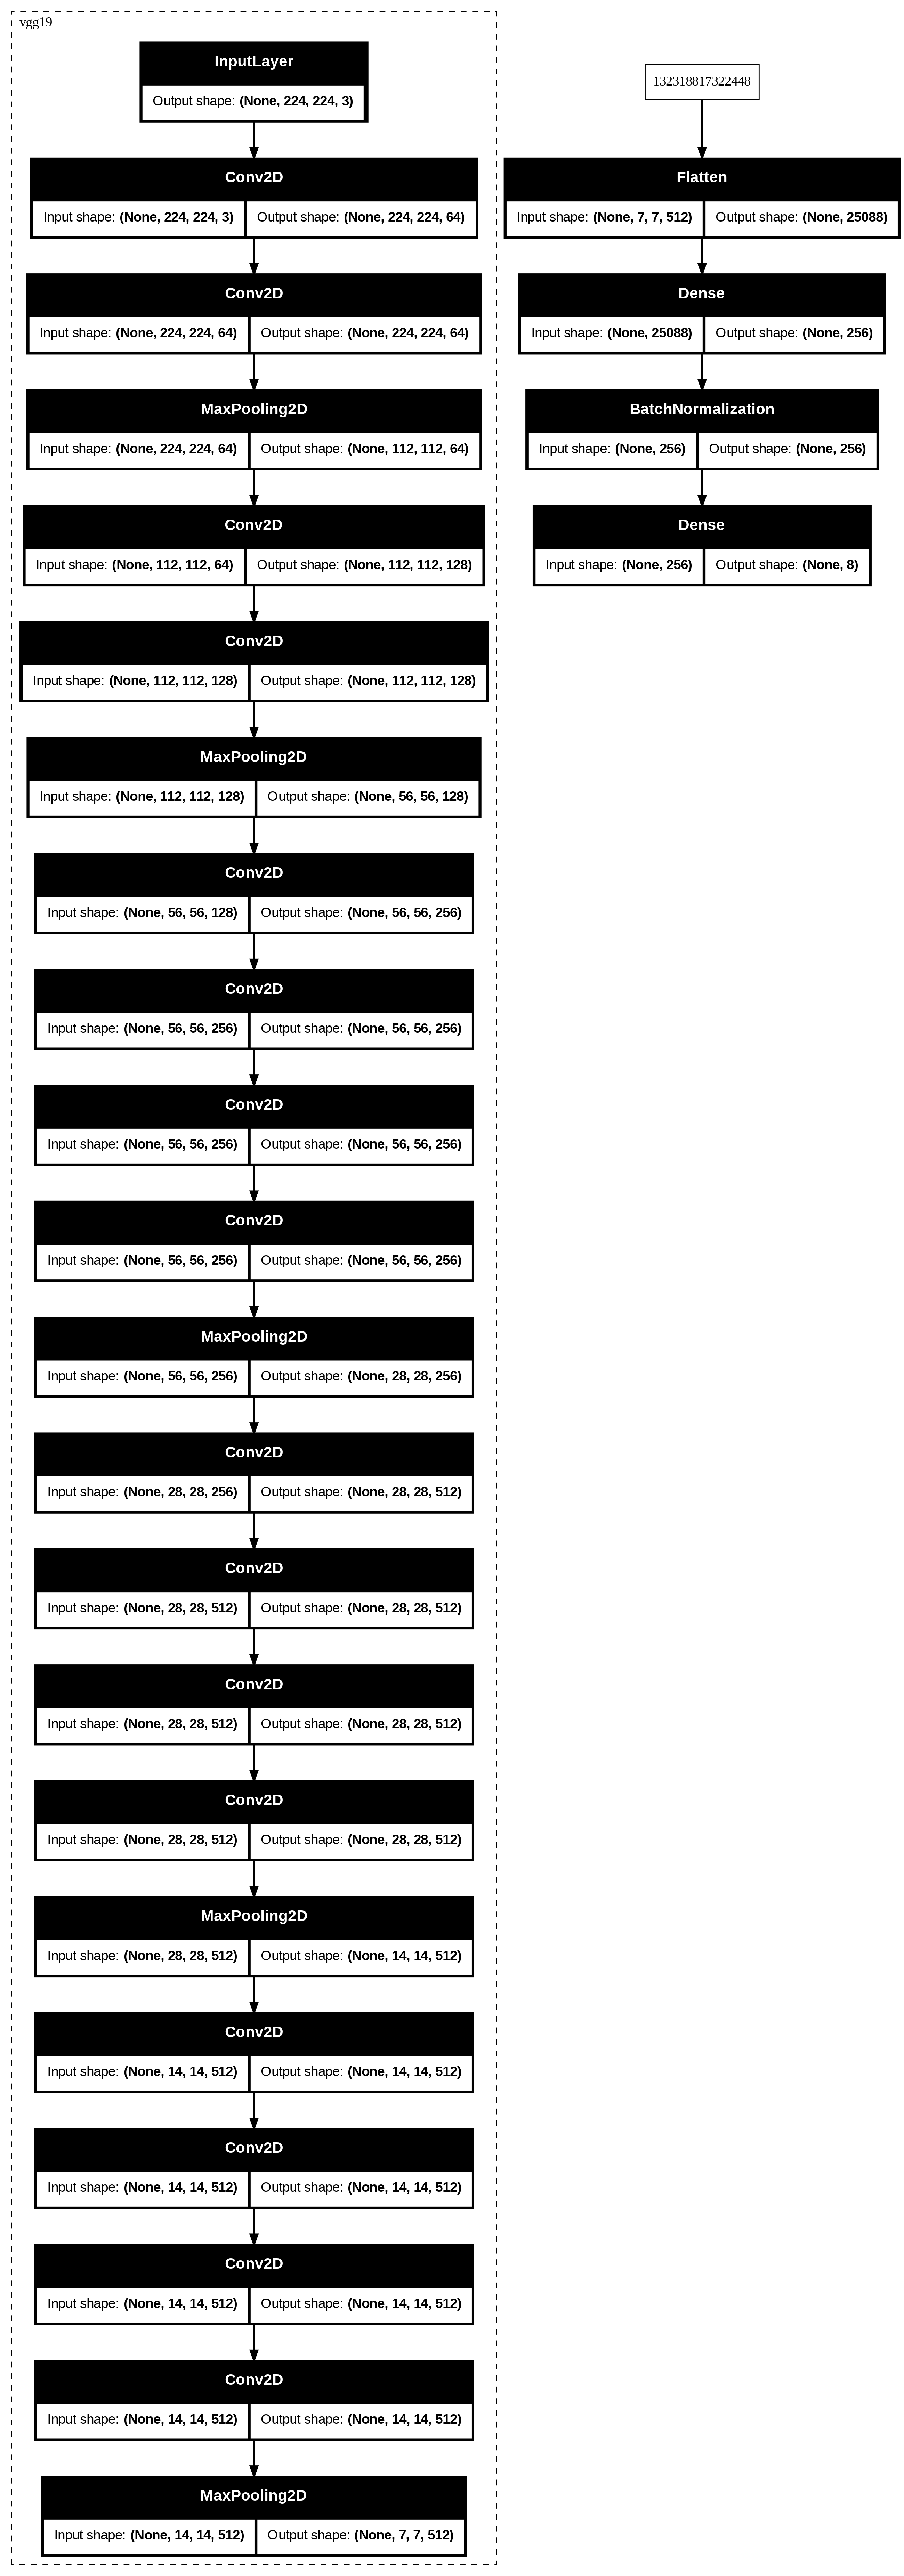

In [34]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Fix: Use `save_freq` instead of `period`
checkpoint = ModelCheckpoint("vgg19.h5",
                              monitor="val_acc",
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=False,
                              save_freq="epoch")  # Replaced `period` with `save_freq`

earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)


In [ ]:
his = model.fit(
    train_data,       # Training data
    batch_size=128,    # Batch size for training
    epochs=10,        # Number of training epochs
    validation_data=valid_data,  # Validation data
    verbose=1,        # Verbosity level for training logs
    callbacks=[checkpoint, earlystop]  # Callback functions
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 12/346 ━━━━━━━━━━━━━━━━━━━━ 2:05:44 23s/step - accuracy: 0.5153 - loss: 1.9455